In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 6.2 Kernels and Kernel Machines {-}

### 6.2.1 {-}
Write functions to compute the RBF and polynomial kernels.

In [2]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    return np.exp(-cdist(X1,X2,'sqeuclidean')/(2*sigma**2))

def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    return (offset + X1@X2.T)**degree


\newpage

### 6.2.2 {-}
Use the linear kernel function defined in the code to compute the
kernel matrix on the set of points $x_{0}\in\mathcal{D}_{X}=\left\{ -4,-1,0,2\right\}$.
Include both the code and the output.

In [3]:
x0 = np.array([[-4],[-1],[0],[2]])
linear_kernel(x0,x0)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

\newpage

### 6.2.3.a {-}

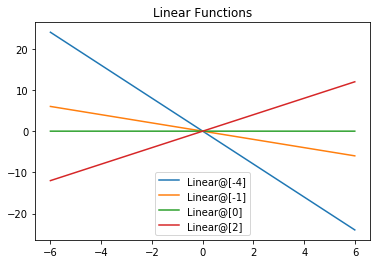

In [4]:
# PLot kernel machine functions
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.title('Linear Functions')
plt.show() 

\newpage

### 6.2.3.b {-}

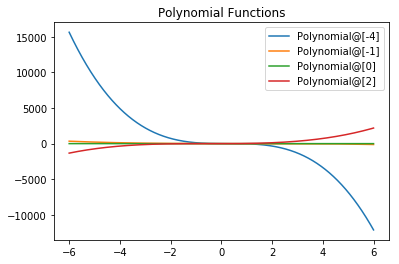

In [5]:
# PLot kernel machine functions
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = polynomial_kernel(prototypes, xpts, 1,3) 
for i in range(len(prototypes)):
    label = "Polynomial@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.title('Polynomial Functions')
plt.show() 

\newpage

### 6.2.3.c {-}

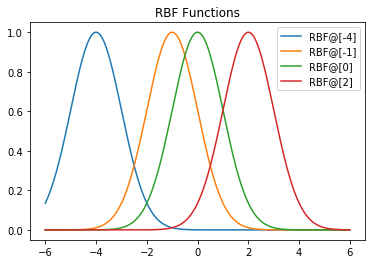

In [6]:
# PLot kernel machine functions
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = RBF_kernel(prototypes, xpts, 1) 
for i in range(len(prototypes)):
    label = "RBF@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.title('RBF Functions')
plt.show() 

\newpage

### 6.2.3.d {-}

In [7]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R with entries w_1,...,w_R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        return self.kernel(X, self.prototype_points)@self.weights

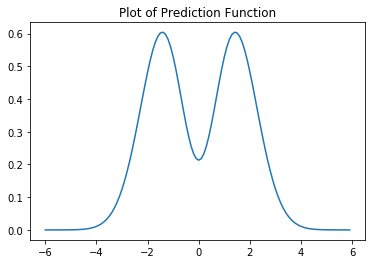

In [8]:
from functools import partial
kernel = partial(RBF_kernel, sigma=1)
x = np.array([[-1],[0],[1]])
w = np.array([1,-1,1])
model = Kernel_Machine(kernel=kernel, prototype_points=x, weights=w)
x_pred = np.arange(-6.0, 6, 0.1).reshape(-1,1)
y_pred = model.predict(x_pred)
plt.plot(x_pred, y_pred)
plt.title("Plot of Prediction Function")
plt.show()

\newpage

## 6.3 Kernel Ridge Regression {-}

Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [5]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

### 6.3.1 {-}
Plot the training data

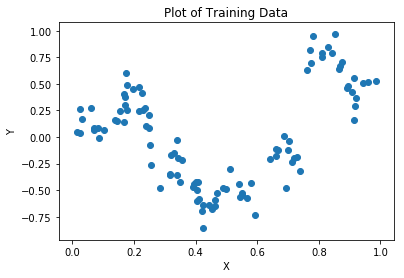

In [10]:
plt.scatter(x_train, y_train)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of Training Data')
plt.show()

\newpage

### 6.3.2 {-}
Complete the function train_kernel_ridge_regression

In [11]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    K = kernel(X,X)
    alpha = np.linalg.inv(l2reg*np.eye(len(X)) + K)@y
    return Kernel_Machine(kernel, X, alpha)

\newpage

### 6.3.3 {-}
Use the code provided to plot your fits to the training data for the
RBF kernel with a fixed regularization parameter of $0.0001$ for
3 different values of sigma: $0.01$, $0.1$, and $1.0$. What values
of sigma do you think would be more likely to over fit, and which
less?

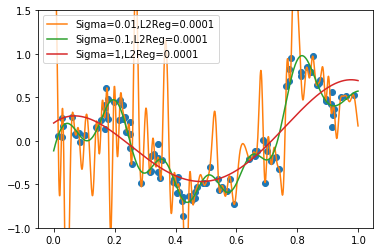

In [12]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

Lower values of $\sigma$ are more prone to overfitting. With lower values of $\sigma$, the final prediction function  is highly dependednt on local values of the training data.

\newpage

### 6.3.4 {-}
Use the code provided to plot your fits to the training data for the
RBF kernel with a fixed sigma of $0.02$ and 4 different values of
the regularization parameter $\lambda$: $0.0001$, $0.01$, $0.1$,
and $2.0$. What happens to the prediction function as $\lambda\to\infty$?

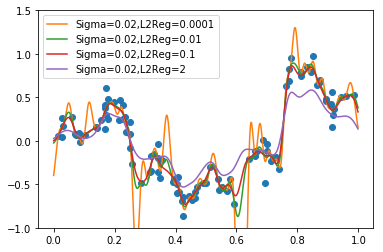

In [13]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

As $\lambda\to\infty$, the weights become smaller, eventually reaching 0. At this point the prediction function is just 0 for all x.

\newpage

In [ ]:
def sigmoid_kernel(X1, X2, eta, nu):
    return np.tanh(eta*X1@X2.T+nu)

In [30]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1, eta=1, nu=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 
        self.eta = eta
        self.nu = nu

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        elif self.kernel == 'sigmoid':
            self.k = functools.partial(sigmoid_kernel, eta=self.eta, nu=self.nu)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [6]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [55]:
param_grid = [{'kernel': ['RBF'],'sigma':np.linspace(0.01,1,25), 'l2reg': np.logspace(1e-5,10, 20)},
              {'kernel':['polynomial'],'offset':np.linspace(-5,5,25), 'degree':[2,3,4,5,6],'l2reg':np.linspace(0.01,1,25) },
              {'kernel':['linear'],'l2reg': np.linspace(0.1,10,50)}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                    ,n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                    ,verbose=0
                   )
_ = grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

In [ ]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow = df_toshow.sort_values(by=["mean_test_score"])

\newpage

### 6.3.5 {-}
Perform hyperparameter search and provide a summary of the results for each kernel

#### Best params for RBF {-}

In [57]:
df_toshow[df_toshow.param_kernel=='RBF'].head()

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
1,-,RBF,1.000023,-,0.05125,0.015609,0.018215
26,-,RBF,3.359892,-,0.05125,0.025470,0.031895
2,-,RBF,1.000023,-,0.0925,0.026406,0.029071
4,-,RBF,1.000023,-,0.175,0.028863,0.040367
3,-,RBF,1.000023,-,0.13375,0.028890,0.034944


#### Best params for Polynomial Kernel {-}

In [58]:
df_toshow[df_toshow.param_kernel=='polynomial'].head()

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
3042,6,polynomial,0.05125,2.08333,-,0.032453,0.049113
3069,6,polynomial,0.09250,2.91667,-,0.032517,0.048018
3095,6,polynomial,0.13375,3.33333,-,0.032600,0.048699
3121,6,polynomial,0.17500,3.75,-,0.032672,0.048877
3096,6,polynomial,0.13375,3.75,-,0.032692,0.046910


#### Best params for Linear {-}

In [59]:
df_toshow[df_toshow.param_kernel=='linear'].head()

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
3644,-,linear,3.938776,-,-,0.16451,0.206561
3643,-,linear,3.736735,-,-,0.16451,0.206556
3645,-,linear,4.140816,-,-,0.16451,0.206567
3642,-,linear,3.534694,-,-,0.16451,0.206551
3646,-,linear,4.342857,-,-,0.16451,0.206572


\newpage

### 6.3.6 {-}
Plot the best fitting prediction functions using the polynomial and RBF kernels.

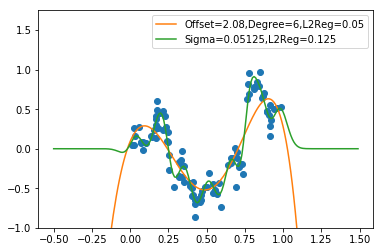

In [60]:
## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
offset= 2.08
degree = 6
l2reg = 0.05
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
sigma = 0.05125
l2reg= 0.125000
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

The RBF kernel fits the data much better. Another thing to note is that outside the domain of x values that the model saw, it predicts approximately 0 while the polynomial kernel quickly goes to $-\infty$ on both ends. This means that most likely, the RBF would perform better with predicting new data that fell outside the range of observed values.

\newpage

### 6.3.7 {-}

The Bayes prediction function is 
\begin{align*}
f^* &= E(Y\vert X) = f(x)
\end{align*}

The risk of this function is
\begin{align*}
R(f^*) &= E\big[l(f^*(x), y)\big]\\
&= E\big[(f^*(x)-f(x)-\epsilon)^2\big]\\
&= E\big[(f(x)-f(x)-\epsilon)^2\big]\\
&= E\big[\epsilon^2\big]\\
&= Var(\epsilon)\\
&= 0.1^2
\end{align*}

\newpage

### 6.3.8 {-}
Attempt to improve performance by using different kernel functions.

In [61]:
def sigmoid_kernel(X1, X2, eta, nu):
    return np.tanh(eta*X1@X2.T+nu)

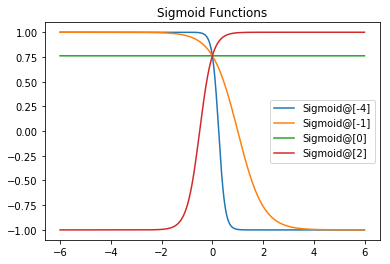

In [62]:
# PLot kernel machine functions
plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Sigmoid kernel
y = sigmoid_kernel(prototypes, xpts, 1,1) 
for i in range(len(prototypes)):
    label = "Sigmoid@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.title('Sigmoid Functions')
plt.show() 

In [63]:
param_grid = {'eta': np.linspace(0, 10, 10),
             'nu': np.logspace(-2, 0, 10),
            'l2reg': np.logspace(-7,-5, 15),
             'kernel': ['sigmoid']}
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,
                                          greater_is_better = False)
                    ,n_jobs = -1
                    ,verbose=0
                   )
_ = grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

In [64]:
df2 = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df2['mean_test_score'] = -df2['mean_test_score']
df2['mean_train_score'] = -df2['mean_train_score']
cols_to_keep = ["param_eta", "param_nu","mean_test_score",
                "mean_train_score", "param_l2reg"]
df2 = df2[cols_to_keep]
df2 = df2.sort_values(by=["mean_test_score"])
df2.head()

,param_eta,param_nu,mean_test_score,mean_train_score,param_l2reg
900,6.66667,0.01,0.020141,0.025288,1e-07
901,6.66667,0.016681,0.020214,0.025650,1e-07
902,6.66667,0.0278256,0.020612,0.026430,1e-07
1354,10,0.0774264,0.021767,0.025143,1e-07
1362,10,0.0278256,0.021950,0.024905,1.3895e-07


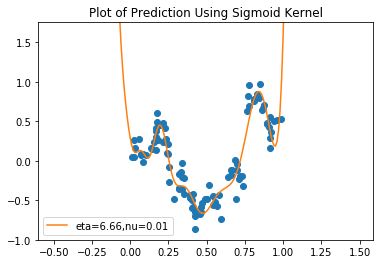

In [65]:
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best sigmoid fit
eta = 6.66
nu= 0.01
l2reg = 1e-7
k = functools.partial(sigmoid_kernel, eta=eta, nu=nu)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "eta="+str(eta)+",nu="+str(nu)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.title("Plot of Prediction Using Sigmoid Kernel")
plt.show()

This didn't improve the test score over using RBF (RBF=0.015, Sigmoid=0.02). However it still fits the data very well.

\newpage

### 6.3.9 {-}
Use any machine learning model to get the best performance you can.

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats.distributions import uniform
param_dist = {'learning_rate': uniform(0.01,1),
              'n_estimators': randint(1,50),
              'min_samples_leaf': randint(1,5),
              'max_depth': randint(2,5)}
grid = RandomizedSearchCV(GradientBoostingRegressor(), 
                            param_dist,
                            cv = predefined_split,
                            scoring = make_scorer(mean_squared_error,
                                                  greater_is_better = False)
                            ,n_jobs = -1  
                            ,verbose=0
                            , n_iter=500
                           )              
_ = grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

In [73]:
pd.set_option('display.max_rows', 20)
df2 = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df2['mean_test_score'] = -df2['mean_test_score']
df2['mean_train_score'] = -df2['mean_train_score']
cols_to_keep = ["param_learning_rate", "param_n_estimators",
                "param_min_samples_leaf", 'param_max_depth',
                "mean_test_score","mean_train_score"]
df_toshow2 = df2[cols_to_keep].fillna('-')
df_toshow2 = df_toshow2.sort_values(by=["mean_test_score"])
df_toshow2.head()

,param_learning_rate,param_n_estimators,param_min_samples_leaf,param_max_depth,mean_test_score,mean_train_score
99,0.270287,25,3,4,0.394587,0.032204
308,0.086171,43,2,4,0.395288,0.054924
355,0.211756,43,1,4,0.395995,0.008076
64,0.218163,24,2,4,0.407881,0.039017
9,0.082174,30,2,4,0.408592,0.088934


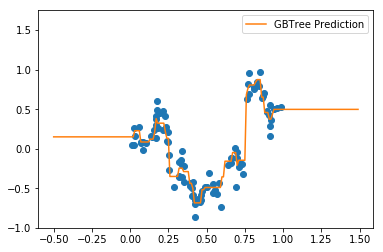

In [8]:
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
f = grid.best_estimator_
plt.plot(xpts, f.predict(xpts), label='GBTree Prediction')
plt.legend()
plt.ylim(-1,1.75)
plt.show()

Usign gradient boosted trees resulted in an improved test score over RBF SVF. (RBF=0.15, GBT=0.013)

\newpage

## 6.4 Kernalized Support Vector Machines with Kernalized Pegasos {-}

### 6.4.1 {-}
Load the SVM training and test data from the zip file.
Plot the training data using the code supplied. Are the data linearly
separable? Quadratically separable? What if we used some RBF kernel?

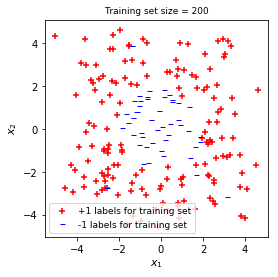

In [69]:
# Load and plot the SVM data
#load the training and test sets
data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r',
                     label = '+1 labels for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b',
                      label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

The data is not linearly or quadratically seperable. However, an RBF kernel could separate it,

\newpage

In [70]:
# Code to help plot the decision regions
# (Note: This ode isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
sigma=1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_soft_svm(x_train, y_train, k, ...)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b',
                     label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b',
                      label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

NameError: name 'train_soft_svm' is not defined